In [ ]:
About LSTM :-
What is LSTM?
LSTM (Long Short-Term Memory) is a special type of neural network designed to remember patterns over time.
Simple Analogy:
Imagine you're predicting tomorrow's weather. A regular neural network only looks at today's data. But LSTM is like a person who remembers:

Yesterday was cold
Last week had a warming trend
This pattern happened last month too

LSTM "remembers" important past information while "forgetting" irrelevant details.
---------------------------------------------------------------------------------------------------------------------------------------------------
How LSTM Works (Simplified)
LSTM has three "gates" that control information flow:

Forget Gate: "Should I forget old information?" (e.g., yesterday's temp might not matter for next week)
Input Gate: "What new information should I remember?" (e.g., sudden temperature drop is important)
Output Gate: "What should I predict based on what I remember?"

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
--2026-01-16 04:53:46--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  --.-KB/s    in 0.07s   

2026-01-16 04:53:47 (185 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
Dataset Shape: (420551, 15)

First few rows:
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.4

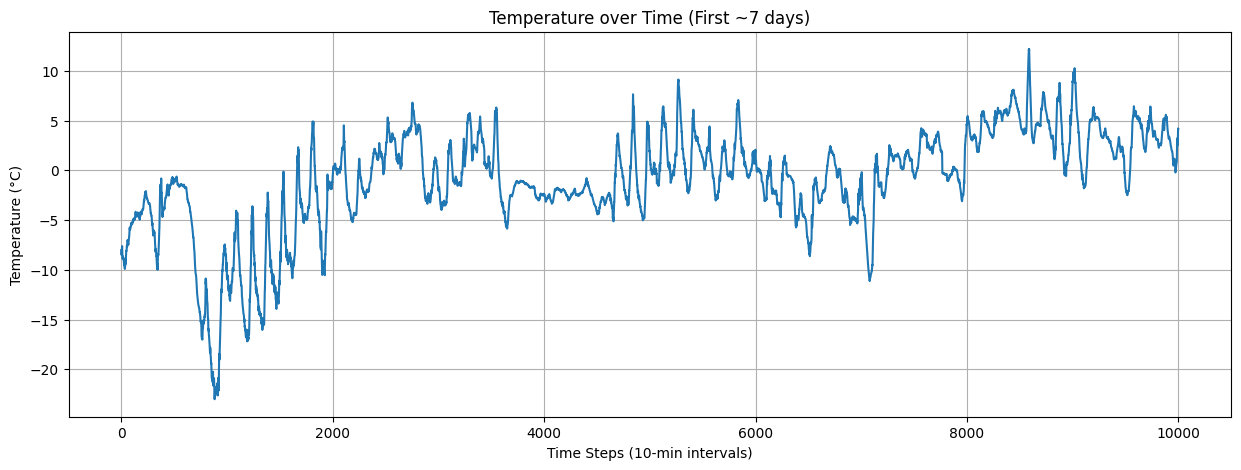

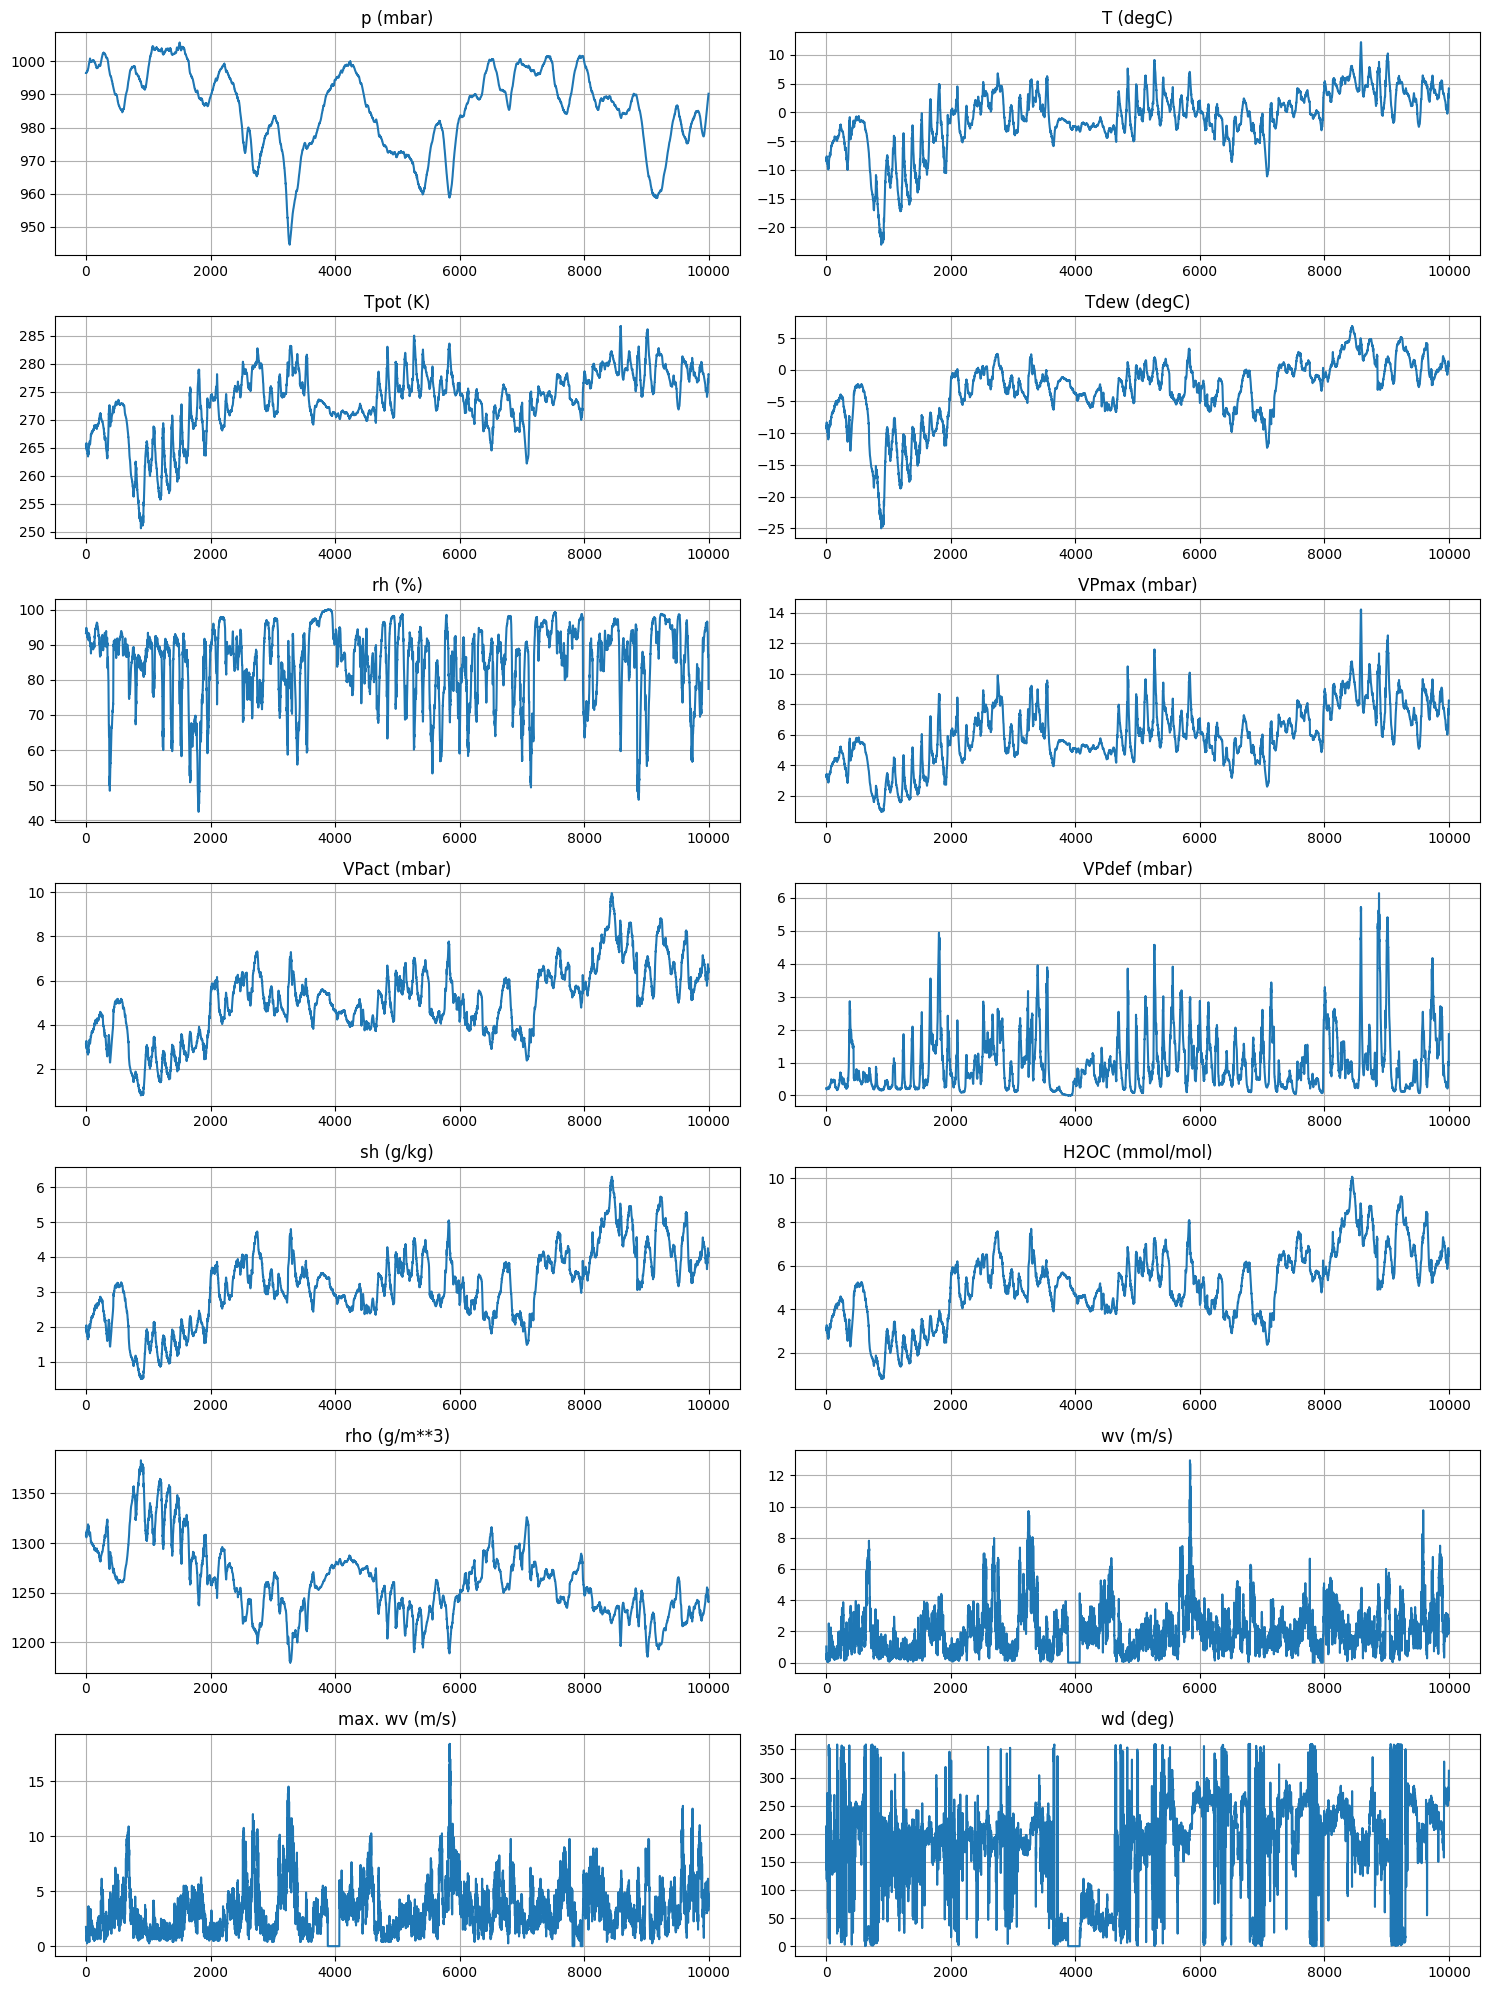

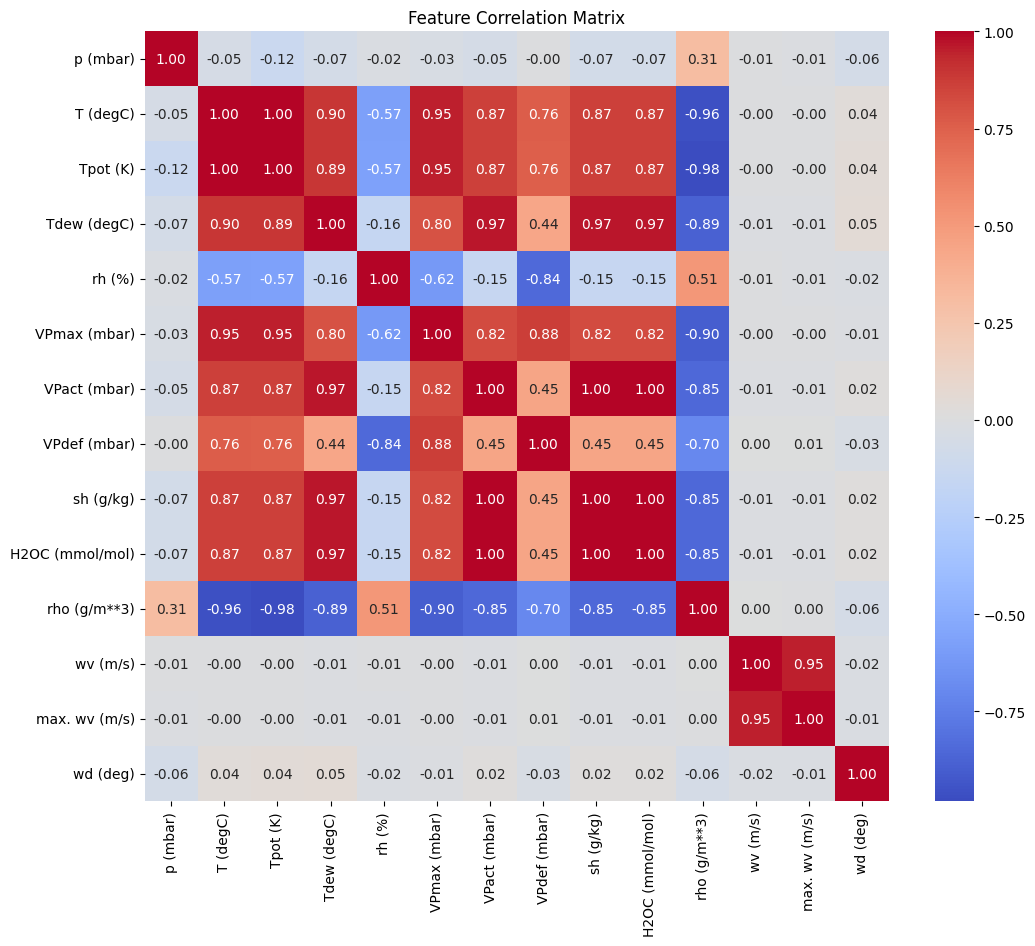

Data shape after removing datetime: (420551, 14)

Train size: 294385
Validation size: 84110
Test size: 42056

Data normalized! Mean ~0, Std ~1
Creating sequences with lookback = 432 timesteps

--- Creating 1-Hour Ahead Sequences ---


In [ ]:


"""
WHAT IS LSTM?
-------------
LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN)
designed to remember patterns over long sequences of time.

WHY USE LSTM FOR WEATHER?
--------------------------
- Weather has temporal dependencies (past affects future)
- Temperature doesn't change randomly - it follows patterns
- LSTM can "remember" important past information while "forgetting" noise

HOW LSTM WORKS?
---------------
LSTM has 3 gates:
1. Forget Gate: Decides what to forget from previous memory
2. Input Gate: Decides what new information to store
3. Output Gate: Decides what to output based on memory

For weather: LSTM remembers trends (warming/cooling) and forgets random noise
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


# Download Jena Climate Dataset
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
!unzip -o jena_climate_2009_2016.csv.zip

# Load the dataset
df = pd.read_csv('jena_climate_2009_2016.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn Names:")
print(df.columns.tolist())
print("\nData Info:")
print(df.info())


# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Statistical summary
print("\nStatistical Summary:")
print(df.describe())

# Visualize Temperature over time (first 10000 records for speed)
plt.figure(figsize=(15, 5))
plt.plot(df['T (degC)'][:10000])
plt.title('Temperature over Time (First ~7 days)')
plt.xlabel('Time Steps (10-min intervals)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

# Visualize all 14 features
fig, axes = plt.subplots(7, 2, figsize=(15, 20))
axes = axes.ravel()

for idx, col in enumerate(df.columns[1:]):  # Skip Date Time column
    axes[idx].plot(df[col][:10000])
    axes[idx].set_title(col)
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.iloc[:, 1:].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


"""
KEY PREPROCESSING STEPS:
1. Remove Date Time column (not needed for LSTM)
2. Handle missing values (if any)
3. Normalize data (LSTM works better with normalized inputs)
4. Create sequences (lookback window of 3 days)
"""

# Remove Date Time column
data = df.iloc[:, 1:].values  # All features except datetime
print(f"Data shape after removing datetime: {data.shape}")

# Check for any missing values and fill them
if np.isnan(data).any():
    data = pd.DataFrame(data).fillna(method='ffill').fillna(method='bfill').values
    print("Missing values handled!")

# Split data: Train (70%), Val (20%), Test (10%)
train_split = int(0.7 * len(data))
val_split = int(0.9 * len(data))

train_data = data[:train_split]
val_data = data[train_split:val_split]
test_data = data[val_split:]

print(f"\nTrain size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

# Normalize the data using StandardScaler
# IMPORTANT: Fit scaler only on training data to prevent data leakage!
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)

print("\nData normalized! Mean ~0, Std ~1")


"""
SEQUENCE CREATION LOGIC:
- Lookback: 3 days = 3 * 24 * 6 = 432 timesteps (10-min intervals)
- Target 1: Temperature 1 hour ahead = 6 steps ahead
- Target 2: Temperature 24 hours ahead = 144 steps ahead

Input shape: (samples, 432, 14)  # 432 timesteps, 14 features
Output shape: (samples, 1)       # Single temperature value
"""

def create_sequences(data, lookback, target_step, target_column=0):
    """
    Create sequences for LSTM training

    Args:
        data: Normalized data array
        lookback: Number of past timesteps to use (3 days = 432)
        target_step: Steps ahead to predict (6 for 1hr, 144 for 24hr)
        target_column: Column index of target (0 for temperature)

    Returns:
        X: Input sequences
        y: Target values
    """
    X, y = [], []

    for i in range(lookback, len(data) - target_step):
        # Input: past 'lookback' timesteps with all features
        X.append(data[i - lookback:i])

        # Output: temperature at 'target_step' ahead
        y.append(data[i + target_step, target_column])

    return np.array(X), np.array(y)

# Configuration
LOOKBACK = 3 * 24 * 6  # 3 days = 432 timesteps
TARGET_1HR = 6         # 1 hour ahead
TARGET_24HR = 144      # 24 hours ahead
TEMP_COLUMN = 0        # Temperature is the first column

print(f"Creating sequences with lookback = {LOOKBACK} timesteps")

# Create sequences for 1-hour prediction
print("\n--- Creating 1-Hour Ahead Sequences ---")
X_train_1hr, y_train_1hr = create_sequences(train_data, LOOKBACK, TARGET_1HR, TEMP_COLUMN)
X_val_1hr, y_val_1hr = create_sequences(val_data, LOOKBACK, TARGET_1HR, TEMP_COLUMN)
X_test_1hr, y_test_1hr = create_sequences(test_data, LOOKBACK, TARGET_1HR, TEMP_COLUMN)

print(f"X_train_1hr shape: {X_train_1hr.shape}")  # (samples, 432, 14)
print(f"y_train_1hr shape: {y_train_1hr.shape}")  # (samples,)

# Create sequences for 24-hour prediction
print("\n--- Creating 24-Hour Ahead Sequences ---")
X_train_24hr, y_train_24hr = create_sequences(train_data, LOOKBACK, TARGET_24HR, TEMP_COLUMN)
X_val_24hr, y_val_24hr = create_sequences(val_data, LOOKBACK, TARGET_24HR, TEMP_COLUMN)
X_test_24hr, y_test_24hr = create_sequences(test_data, LOOKBACK, TARGET_24HR, TEMP_COLUMN)

print(f"X_train_24hr shape: {X_train_24hr.shape}")
print(f"y_train_24hr shape: {y_train_24hr.shape}")


"""
MODEL ARCHITECTURE CHOICES:
----------------------------
1. Input Layer: Accepts sequences of shape (432, 14)

2. LSTM Layer 1 (128 units):
   - WHY 128? Enough capacity to learn complex patterns without overfitting
   - return_sequences=True: Passes sequences to next LSTM layer

3. Dropout (0.3):
   - WHY? Prevents overfitting by randomly dropping 30% of neurons

4. LSTM Layer 2 (64 units):
   - WHY 64? Gradually reduce dimensions for better generalization
   - return_sequences=False: Only output final hidden state

5. Dropout (0.3):
   - Again for regularization

6. Dense Layer (32 units):
   - WHY? Adds non-linear transformation before final output

7. Output Layer (1 unit):
   - Single temperature prediction

OPTIMIZER: Adam (adaptive learning rate, works well for time series)
LOSS: MSE (Mean Squared Error - standard for regression)
METRICS: MAE (Mean Absolute Error - easier to interpret)
"""

def build_lstm_model(input_shape, name="LSTM_Model"):
    """
    Build LSTM model for temperature prediction
    """
    model = Sequential(name=name)

    # LSTM Layer 1
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))

    # LSTM Layer 2
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))

    # Dense layers
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output: single temperature value

    # Compile
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    return model

# Build models
input_shape = (LOOKBACK, X_train_1hr.shape[2])  # (432, 14)

model_1hr = build_lstm_model(input_shape, name="LSTM_1Hour")
model_24hr = build_lstm_model(input_shape, name="LSTM_24Hour")

print("\n--- 1-Hour Model Architecture ---")
model_1hr.summary()

print("\n--- 24-Hour Model Architecture ---")
model_24hr.summary()

"""
CALLBACKS:
----------
1. EarlyStopping: Stop training if validation loss doesn't improve
   - Prevents overfitting and saves time

2. ReduceLROnPlateau: Reduce learning rate when learning plateaus
   - Helps model converge better
"""

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stop, reduce_lr]


EPOCHS = 50
BATCH_SIZE = 128

print("\n" + "="*60)
print("TRAINING 1-HOUR AHEAD MODEL")
print("="*60)

history_1hr = model_1hr.fit(
    X_train_1hr, y_train_1hr,
    validation_data=(X_val_1hr, y_val_1hr),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("TRAINING 24-HOUR AHEAD MODEL")
print("="*60)

history_24hr = model_24hr.fit(
    X_train_24hr, y_train_24hr,
    validation_data=(X_val_24hr, y_val_24hr),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)



def evaluate_model(model, X_test, y_test, scaler, model_name):
    """
    Evaluate model and denormalize predictions
    """
    # Predict
    y_pred_scaled = model.predict(X_test).flatten()

    dummy = np.zeros((len(y_pred_scaled), scaler.scale_.shape[0]))
    dummy[:, 0] = y_pred_scaled
    y_pred = scaler.inverse_transform(dummy)[:, 0]

    dummy[:, 0] = y_test
    y_true = scaler.inverse_transform(dummy)[:, 0]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"\n{model_name} Performance:")
    print(f"  MAE:  {mae:.4f} °C")
    print(f"  RMSE: {rmse:.4f} °C")

    return y_true, y_pred, mae, rmse

# Evaluate both models
y_true_1hr, y_pred_1hr, mae_1hr, rmse_1hr = evaluate_model(
    model_1hr, X_test_1hr, y_test_1hr, scaler, "1-Hour Model"
)

y_true_24hr, y_pred_24hr, mae_24hr, rmse_24hr = evaluate_model(
    model_24hr, X_test_24hr, y_test_24hr, scaler, "24-Hour Model"
)


# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history_1hr.history['loss'], label='Train Loss')
axes[0, 0].plot(history_1hr.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('1-Hour Model: Loss Over Epochs')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history_1hr.history['mae'], label='Train MAE')
axes[0, 1].plot(history_1hr.history['val_mae'], label='Val MAE')
axes[0, 1].set_title('1-Hour Model: MAE Over Epochs')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(history_24hr.history['loss'], label='Train Loss')
axes[1, 0].plot(history_24hr.history['val_loss'], label='Val Loss')
axes[1, 0].set_title('24-Hour Model: Loss Over Epochs')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss (MSE)')
axes[1, 0].legend()
axes[1, 0].grid(True)


axes[1, 1].plot(history_24hr.history['mae'], label='Train MAE')
axes[1, 1].plot(history_24hr.history['val_mae'], label='Val MAE')
axes[1, 1].set_title('24-Hour Model: MAE Over Epochs')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Plot predictions vs actual
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 1-Hour Predictions
sample_range = 500
axes[0].plot(y_true_1hr[:sample_range], label='Actual', alpha=0.7)
axes[0].plot(y_pred_1hr[:sample_range], label='Predicted', alpha=0.7)
axes[0].set_title(f'1-Hour Ahead Predictions (MAE: {mae_1hr:.4f}°C, RMSE: {rmse_1hr:.4f}°C)')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()
axes[0].grid(True)

# 24-Hour Predictions
axes[1].plot(y_true_24hr[:sample_range], label='Actual', alpha=0.7)
axes[1].plot(y_pred_24hr[:sample_range], label='Predicted', alpha=0.7)
axes[1].set_title(f'24-Hour Ahead Predictions (MAE: {mae_24hr:.4f}°C, RMSE: {rmse_24hr:.4f}°C)')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Temperature (°C)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Scatter plot: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(y_true_1hr, y_pred_1hr, alpha=0.3)
axes[0].plot([y_true_1hr.min(), y_true_1hr.max()],
             [y_true_1hr.min(), y_true_1hr.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Temperature (°C)')
axes[0].set_ylabel('Predicted Temperature (°C)')
axes[0].set_title('1-Hour Model: Predicted vs Actual')
axes[0].grid(True)

axes[1].scatter(y_true_24hr, y_pred_24hr, alpha=0.3)
axes[1].plot([y_true_24hr.min(), y_true_24hr.max()],
             [y_true_24hr.min(), y_true_24hr.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Temperature (°C)')
axes[1].set_ylabel('Predicted Temperature (°C)')
axes[1].set_title('24-Hour Model: Predicted vs Actual')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 11: SAVE MODELS
# ============================================================================

model_1hr.save('lstm_1hour_model.h5')
model_24hr.save('lstm_24hour_model.h5')
print("\nModels saved successfully!")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"\n1-Hour Ahead Model:")
print(f"  - MAE:  {mae_1hr:.4f} °C")
print(f"  - RMSE: {rmse_1hr:.4f} °C")
print(f"\n24-Hour Ahead Model:")
print(f"  - MAE:  {mae_24hr:.4f} °C")
print(f"  - RMSE: {rmse_24hr:.4f} °C")
print("\n" + "="*60)

"""
HYPERPARAMETER EXPERIMENTS TO TRY:
-----------------------------------
1. Change LSTM units: Try [64, 32] or [256, 128]
2. Add more LSTM layers: 3 or 4 layers
3. Adjust dropout: Try 0.2 or 0.4
4. Change batch size: Try 64 or 256
5. Different optimizers: Try 'rmsprop' or 'sgd'
6. Adjust lookback window: Try 2 days or 4 days

Document your experiments in Markdown cells!
"""

# New section